This notebook contains our baseline domain adaptation model implementation and results. 

# Imports

The code for importing the data is largely the same as the following notebook: https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaelmcgillicuddy","key":"f5963b5d01f0654e67127d5906c0565a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 736M/745M [00:06<00:00, 121MB/s]
100% 745M/745M [00:06<00:00, 113MB/s]


In [ ]:
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [ ]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

# Setup of Data

This section creates the file structures necessary to process the data and loads it into the appropriate DataLoader objects for analysis with PyTorch. We also do data augmentation in this section. The code for setting up the data is adapted from https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18. Some of the changes we made were to adapt the code to use healthy and unhealthy classes instead of pneumonia & no-pneumonia and to add code for setting up our domain adapatation dataset. 



In [ ]:
from distutils.dir_util import copy_tree

directory ='/content/COVID-19_Radiography_Dataset'

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']
input_dir = '/content/train'
output_dir = '/content/test'

normal_dir = '/content/COVID-19_Radiography_Dataset/Normal'
viral_dir = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia'
covid_dir = '/content/COVID-19_Radiography_Dataset/COVID'
    
if os.path.isdir(os.path.join(directory, source_dirs[1])):
    if os.path.exists(input_dir):
      shutil.rmtree(input_dir)
    
    # Create Train Dir  
    os.mkdir(input_dir)
    os.makedirs(input_dir + '/Normal')
    os.makedirs(input_dir + '/Viral Pneumonia')
    os.makedirs(input_dir + '/COVID')             
        
    # Copy Classes to Train
    copy_tree(normal_dir, input_dir + '/Normal')
    copy_tree(viral_dir, input_dir + '/Viral Pneumonia')
    copy_tree(covid_dir, input_dir + '/COVID')
    
    # Create Test Dir   
    if os.path.exists(output_dir):
      shutil.rmtree(output_dir)         

    os.makedirs(output_dir)            
    os.makedirs(output_dir + '/Normal')
    os.makedirs(output_dir + '/Viral Pneumonia')
    os.makedirs(output_dir + '/COVID')   
    
    # Create Test Dir Classes
    for c in source_dirs:
        if not os.path.isdir(os.path.join(output_dir, c)):
            os.mkdir(os.path.join(output_dir, c))

    # Choose 200 images per type to be moved to test      
    for c in source_dirs:
        images = [x for x in os.listdir(os.path.join(input_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 200)
        for image in selected_images:
            source_path = os.path.join(input_dir, c, image)
            target_path = os.path.join(output_dir, c, image)
            shutil.move(source_path, target_path)

In [ ]:
#code for initializing and transforming the datasets
class ChestXRayDataset(torch.utils.data.Dataset): 
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Healthy', 'Unhealthy']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


In [ ]:
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
# We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
train_dirs = {
    'Healthy': input_dir + '/Normal',
    'Unhealthy': input_dir + '/Viral Pneumonia'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9992 Healthy examples
Found 1145 Unhealthy examples


In [ ]:
test_dirs = {
    'Healthy': output_dir + '/Normal',
    'Unhealthy': output_dir + '/Viral Pneumonia'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 200 Healthy examples
Found 200 Unhealthy examples


In [ ]:
base_DA_dirs = {
    'Healthy': output_dir + '/Normal',
    'Unhealthy': output_dir + '/COVID' 
}

base_DA_dataset = ChestXRayDataset(base_DA_dirs, test_transform)

Found 200 Healthy examples
Found 200 Unhealthy examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dl_baseDA = torch.utils.data.DataLoader(base_DA_dataset, batch_size=batch_size, shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))
print('Num of base DA batches', len(dl_baseDA))

Num of training batches 1857
Num of test batches 67
Num of base DA batches 67


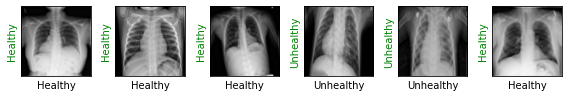

In [ ]:
class_names = train_dataset.class_names
def show_images(images,labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks =[]) # x & y ticks are set to blank
        image = image.numpy().transpose((1, 2, 0)) # Channel first, then height and width
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
images, labels = next(iter(dl_train)) #Fetch the next batch of images
show_images(images, labels, labels)

# Model Definition

This section defines the neural network architecture for the model. We used a resnet model, which is a CNN pre-trained on ImageNet. This section is adapted from https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18. We switched from resnet 18 to resnet 152. 

In [ ]:
resnet152 = torchvision.models.resnet152(pretrained=True)
resnet152.fc = torch.nn.Linear(in_features=2048, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet152.parameters(), lr=3e-5)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


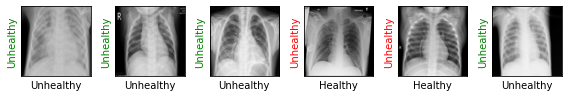

In [ ]:
def show_preds():
    resnet152.eval()  #Setting the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet152(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
show_preds()

# Testing, training, and results

This is the code we used to train, test, and execute our model, also adapted from https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18. It takes around 15 minutes to run the model each time. The accuracy results varied slightly each time we trained and ran the model.

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        resnet152.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet152(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet152.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet152(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet152.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')


Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.7453, Accuracy: 0.4775


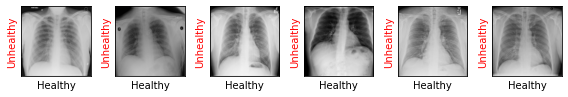

Evaluating at step 20
Validation Loss: 0.2623, Accuracy: 0.9250


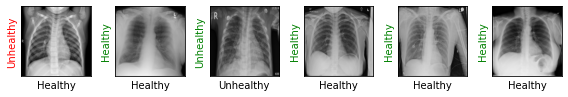

Evaluating at step 40
Validation Loss: 0.1214, Accuracy: 0.9825


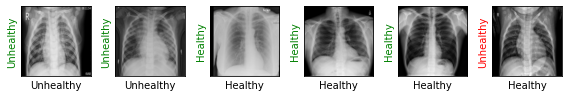

Performance condition satisfied, stopping..


In [ ]:
train(epochs=1)

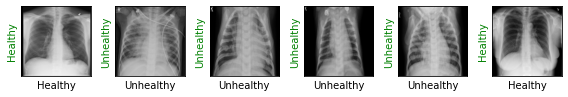

In [ ]:
show_preds()

In [ ]:
# Test the trained binary model on COVID-19 data
with torch.no_grad():
  accuracy = 0
  resnet152.eval()

  # copied code from above
  for val_step, (images, labels) in enumerate(dl_baseDA):
    outputs = resnet152(images)
    loss = loss_fn(outputs, labels)

    _, preds = torch.max(outputs, 1)
    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc
  accuracy = accuracy/len(base_DA_dataset)
  print('='*15)
  print(f'Base DA Accuracy: {accuracy:.4f}')

Base DA Accuracy: 0.4950
